In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
import cuquantum

In [2]:
## First, get 1k MNIST data of only 2-type each. And  

mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
Y = mnist.target.to_numpy().astype(int)
class_list = [7,9]
c01 = np.where((Y == class_list[0])|(Y == class_list[1]))
X,Y = X[c01],Y[c01]
MAX=500
data_train, label_train = X[:MAX],Y[:MAX]
X_train, X_val, Y_train, Y_val = train_test_split(data_train, label_train, test_size = 0.2, random_state=255)

In [3]:
print('train & val shape:',X_train.shape, X_val.shape)
print('train class count:',len(Y_train[np.where(Y_train==class_list[0])]),len(Y_train[np.where(Y_train==class_list[1])]))
print('test  class count:',len(Y_val[np.where(Y_val==class_list[0])]),len(Y_val[np.where(Y_val==class_list[1])]))

train & val shape: (400, 784) (100, 784)
train class count: 211 189
test  class count: 52 48


In [4]:
nb1,nb2=10,5
def data_prepare(n_dim, sample_train, sample_test):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:nb1]
    sample_test = minmax_scale.transform(sample_test)[:nb2]
    return sample_train, sample_test
def svm_score(sample_train,labels_train,sample_val,labels_val):
    parameters = {'C':[1], 'gamma': [0.001, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 50, 100, 1000]}
    svc_grid_search = SVC(kernel="rbf")
    clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')
    clf.fit(sample_train,labels_train)
    result1=clf.score(sample_train,labels_train)
    result2=clf.score(sample_val,labels_val)
    return result1, result2

In [5]:
for q in [2]:
    n_dim = q
    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
    score1, score2 = svm_score(data_train,Y_train[:nb1],data_val,Y_val[:nb2])
    print(n_dim,score1, score2)
#for q in [200,300,400,500,600,784]:
#    n_dim = q
#    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
#    score1, score2 = svm_score(data_train,Y_train[:100],data_val,Y_val[:50])
#    print(n_dim,score1, score2)

2 0.6 0.4


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


## statevector simulation

In [6]:
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc
def all_circuits_parallel(y_t, x_t, indices_list, n_dim, num_cpu):
    psix = make_bsp(n_dim)
    #psix = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear")
    psiy = psix.inverse()
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        circuits = [ psix.assign_parameters(x_t[i2-1]).compose(psiy.assign_parameters(y_t[i1-1])) for i1, i2 in indices_list ]        
        #circuits = pool.starmap(kernel.construct_circuit, [(y_t[i1-1], x_t[i2-1],False) for i1, i2 in indices_list])
    return circuits
def kernel_matrix_svsm(y_t, x_t, circuit,indices_list, simulator, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i = -1
    for i1, i2 in indices_list:
        i += 1
        qc = circuit[i]
        qc.save_statevector()
        circ = transpile(qc, simulator)
        result = simulator.run(circ).result()
        amp = abs(result.get_statevector()[0]) ** 2
        kernel_matrix[i1-1][i2-1] = np.round(amp,8)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [7]:
simulator = Aer.get_backend('aer_simulator_statevector')
#simulator.set_option('cusvaer_enabled', False)
#simulator.set_options(method='statevector', device='GPU')
simulator.set_option('precision', 'double')

In [8]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [9]:
psix = make_bsp(n_dim)
psiy = psix.inverse()
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 50)

In [10]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, 10)
len(circuit_train),len(circuit_val)

(45, 50)

In [11]:
svsm_kernel_matrix_train = kernel_matrix_svsm(data_train, data_train, circuit_train, indices_list_t, simulator, mode="train")
svsm_kernel_matrix_test  = kernel_matrix_svsm(data_val, data_train, circuit_val, indices_list_v, simulator)
print(svsm_kernel_matrix_train)

[[1.0000000e+00 2.9344507e-01 1.3903281e-01 6.4465295e-01 3.8246672e-01
  4.2068012e-01 2.4472696e-01 3.5080255e-01 2.2655007e-01 3.6938208e-01]
 [2.9344507e-01 1.0000000e+00 1.5510200e-03 6.7127575e-01 6.8602573e-01
  8.7677401e-01 9.4729350e-01 7.1718996e-01 7.7812407e-01 7.7380357e-01]
 [1.3903281e-01 1.5510200e-03 1.0000000e+00 6.7931880e-02 1.4934420e-02
  9.8478500e-03 2.4176000e-03 4.3304000e-02 5.9949000e-04 3.8314520e-02]
 [6.4465295e-01 6.7127575e-01 6.7931880e-02 1.0000000e+00 5.4783098e-01
  8.3975912e-01 5.3921719e-01 5.4223523e-01 4.5353901e-01 6.7133499e-01]
 [3.8246672e-01 6.8602573e-01 1.4934420e-02 5.4783098e-01 1.0000000e+00
  7.4971067e-01 7.0673424e-01 8.4119627e-01 8.2042427e-01 7.0141352e-01]
 [4.2068012e-01 8.7677401e-01 9.8478500e-03 8.3975912e-01 7.4971067e-01
  1.0000000e+00 7.5780721e-01 7.2047406e-01 6.7610379e-01 7.6251849e-01]
 [2.4472696e-01 9.4729350e-01 2.4176000e-03 5.3921719e-01 7.0673424e-01
  7.5780721e-01 1.0000000e+00 7.1317960e-01 8.5980666e-01 

In [12]:
## ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#fmap=ZZFeatureMap(n_dim, entanglement='linear')
#qkernel = FidelityQuantumKernel(feature_map=fmap)
#matrix_train = qkernel.evaluate(data_train)
#(svsm_kernel_matrix_train-matrix_train).max()

In [13]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

fmap=make_bsp(n_dim)
qkernel = FidelityQuantumKernel(feature_map=fmap)

matrix_train = qkernel.evaluate(data_train)
(svsm_kernel_matrix_train-matrix_train).max()

4.497330952091261e-09

In [14]:
matrix_test = qkernel.evaluate(data_val,data_train)
(svsm_kernel_matrix_test-matrix_test).max()

4.898527250496443e-09

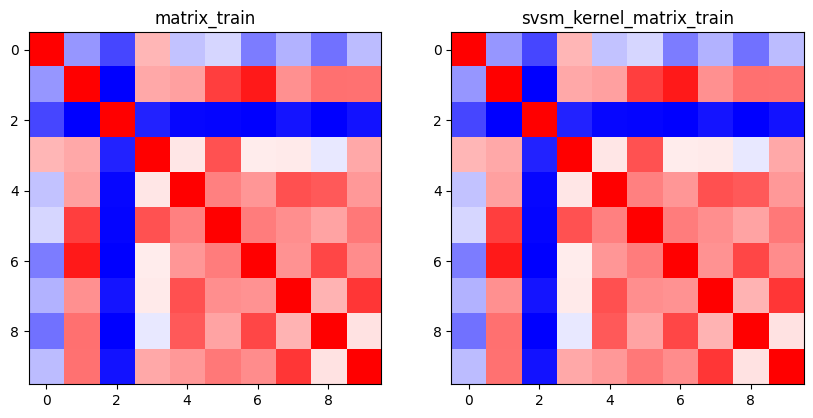

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("matrix_train")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("svsm_kernel_matrix_train")
plt.show()

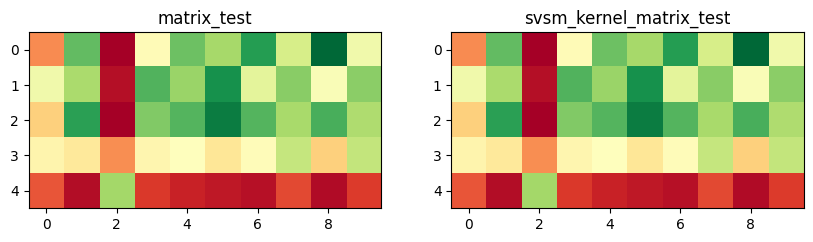

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[0].set_title("matrix_test")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[1].set_title("svsm_kernel_matrix_test")
plt.show()

In [17]:
svc = SVC(kernel="precomputed")
svc.fit(svsm_kernel_matrix_train,Y_train[:nb1])
result1 = svc.score(svsm_kernel_matrix_train,Y_train[:nb1])
result2 = svc.score(svsm_kernel_matrix_test,Y_val[:nb2])
print(result1, result2)

0.9 0.8


---

## tensornetwork simulation

In [51]:
def get_exp(x_t, n_dim, kernel):
    psix = make_bsp(n_dim)
    psiy = psix.inverse()
    circuit = psix.assign_parameters(x_t[0]).compose(psiy.assign_parameters(x_t[0]))
    
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, _ = converter.amplitude(a)  
    return exp
    
def get_operand(circuit,n_dim):
    a = str(0).zfill(n_dim)
    converter = CircuitToEinsum(circuit, backend='numpy')
    _, oper = converter.amplitude(a)  
    return oper    
def all_operands_parallel(circuit, n_dim, num_cpu):
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        indices_list = list(range(len(circuit)))
        operands = pool.starmap(get_operand, [(circuit[i],n_dim) for i in indices_list])
    return operands
def kernel_matrix_tnsm(y_t, x_t, exp, opers, indices_list, options, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i, oper = -1, opers[0]
    with Network(exp, *oper, options=options) as tn:
        tn.contract_path()
        for i1, i2 in indices_list:
            i += 1
            tn.reset_operands(*opers[i])     
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = np.round(amp_tn,8) 
        tn.free()
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [52]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [53]:
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 50)

In [54]:
print(len(data_train))
print(len(data_val))

10
5


In [56]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, qkernel, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, qkernel, 10)

TypeError: all_circuits_parallel() takes 5 positional arguments but 6 were given

In [91]:
oper_train = all_operands_parallel(circuit_train, n_dim, 10)
oper_val   = all_operands_parallel(circuit_val,n_dim,10)
len(oper_train),len(oper_val)

(190, 100)

In [94]:
# oper = oper_train[0]
options = NetworkOptions(blocking="auto")
# network = Network(exp, *oper,options=options)
# path, info = network.contract_path()

In [95]:
exp = get_exp(data_train, n_dim, bsp_kernel_tnsm)

tnsm_kernel_matrix_train = kernel_matrix_tnsm(data_train, data_train, exp, oper_train, indices_list_t, options, mode='train')
tnsm_kernel_matrix_test  = kernel_matrix_tnsm(data_val, data_train, exp, oper_val, indices_list_v, options, mode=None)

In [96]:
tnsm_kernel_matrix_train.shape

(20, 20)

In [97]:
(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()

0.0

In [98]:
(tnsm_kernel_matrix_test-svsm_kernel_matrix_test).max()

0.0

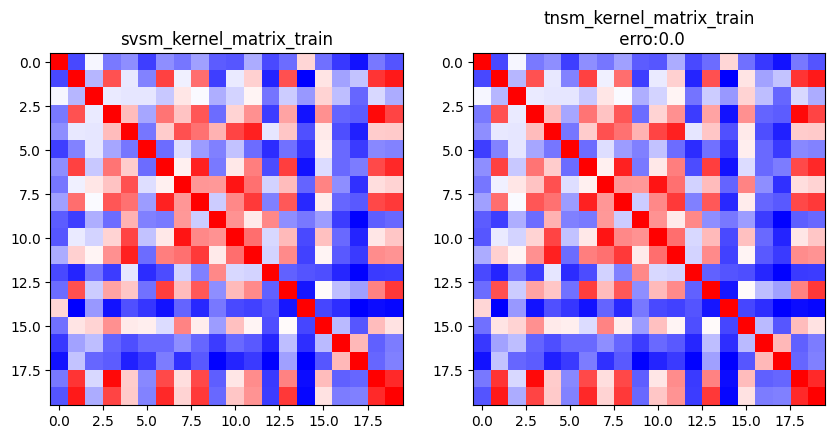

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("svsm_kernel_matrix_train")
axs[1].imshow(np.asmatrix(tnsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title(f"tnsm_kernel_matrix_train\n erro:{(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()}")
plt.show()

In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import circuit_drawer

# Define the number of features
n_features = X_train_reduced.shape[1]  # Number of PCA components

# Create the ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=n_features, entanglement='linear')

# Visualize the circuit
circuit_drawer(feature_map, style={'backgroundcolor': '#ffffff'})


┌─────────────────────────────────────────┐
q_0: ┤0                                        ├
     │                                         │
q_1: ┤1                                        ├
     │                                         │
q_2: ┤2 ZZFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
     │                                         │
q_3: ┤3                                        ├
     │                                         │
q_4: ┤4                                        ├
     └─────────────────────────────────────────┘

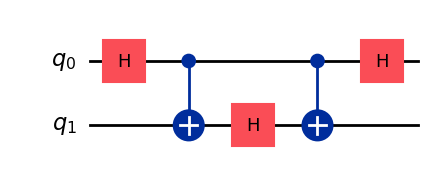

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Create a quantum circuit with 2 qubits
qc = QuantumCircuit(2)

# Add gates to create a circuit with depth 3
qc.h(0)  # Apply Hadamard gate to qubit 0
qc.cx(0, 1)  # Apply CNOT gate with qubit 0 as control and qubit 1 as target
qc.h(1)  # Apply Hadamard gate to qubit 1
qc.cx(0, 1)  # Apply another CNOT gate with qubit 0 as control and qubit 1 as target
qc.h(0)  # Apply another Hadamard gate to qubit 0

# Draw the circuit
circuit_drawer(qc, output='mpl')


In [3]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Create a quantum circuit with 2 qubits
qc = QuantumCircuit(2)

# Add gates to create a circuit with depth 3
qc.h(0)  # Apply Hadamard gate to qubit 0
qc.cx(0, 1)  # Apply CNOT gate with qubit 0 as control and qubit 1 as target
qc.h(1)  # Apply Hadamard gate to qubit 1
qc.cx(0, 1)  # Apply another CNOT gate with qubit 0 as control and qubit 1 as target
qc.h(0)  # Apply another Hadamard gate to qubit 0

# Draw the circuit and get the figure
fig = circuit_drawer(qc, output='mpl')

# Save the figure with 300 DPI
fig.savefig('quantum_circuit.png', dpi=300)


Using GPU:0
10 80 0.042 2.805 10.131 8.405 3160 / 1


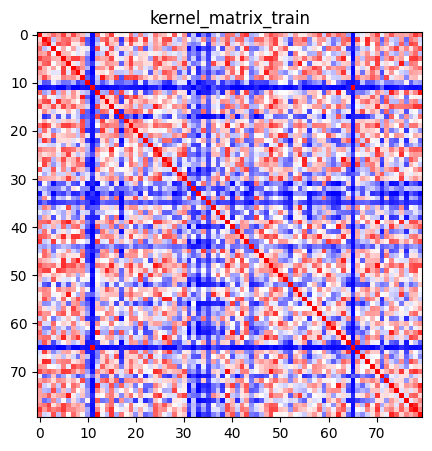

In [6]:
import numpy as np
import scipy.io
import cupy as cp
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from cuquantum import Network, CircuitToEinsum, NetworkOptions
from mpi4py import MPI
import time  # Add this import

# MPI Setup
root = 0
comm_mpi = MPI.COMM_WORLD
rank, size = comm_mpi.Get_rank(), comm_mpi.Get_size()
device_id = 0
cp.cuda.Device(device_id).use()
print(f"Using GPU:{device_id}")

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Features
y = data['labels']     # Labels

# Convert complex values to real if necessary
X = np.real(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature matrix and apply PCA
def data_prepare(nq, sample_train, sample_test, nb1, nb2):
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    
    pca = PCA(n_components=nq, svd_solver="auto").fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:nb1]
    sample_test = minmax_scale.transform(sample_test)[:nb2]
    
    return sample_train, sample_test

# Define the quantum circuit
def make_bsp(nq):
    param = ParameterVector("p", nq)
    bsp_qc = QuantumCircuit(nq)
    bsp_qc.h(list(range(nq)))         # Apply Hadamard gate
    for q in range(nq):               # Apply RZ and RY gates
        bsp_qc.rz(param.params[q], [q])
        bsp_qc.ry(param.params[q], [q])
    for q in range(nq - 1):           # Apply CNOT gates
        bsp_qc.cx(q, q + 1)
    for q in range(nq):               # Apply RZ gates again
        bsp_qc.rz(param.params[q], [q])
    return bsp_qc

def new_op(nq, op, y_t, x_t, izy, izz, iyz):
    new = op[:]
    for i in range(nq):
        d1, d2 = y_t[i], x_t[i]
        z_g = np.array([[np.exp(-1j * 0.5 * d1), 0], [0, np.exp(1j * 0.5 * d1)]])
        z_gd = np.array([[np.exp(1j * 0.5 * d2), 0], [0, np.exp(-1j * 0.5 * d2)]])
        y_g = np.array([[np.cos(d1 / 2), -np.sin(d1 / 2)], [np.sin(d1 / 2), np.cos(d1 / 2)]])
        y_gd = np.array([[np.cos(d2 / 2), np.sin(d2 / 2)], [-np.sin(d2 / 2), np.cos(d2 / 2)]])

        n_zy_g = [z_g]
        n_zy_g.append(y_g)
        new[izy[i]:izy[i] + 2] = cp.array(n_zy_g)

        n_zz_g = [z_g]
        n_zz_g.append(z_gd)
        new[izz[i]:izz[i] + 2] = cp.array(n_zz_g)

        n_zy_g = [y_gd]
        n_zy_g.append(z_gd)
        new[iyz[i]:iyz[i] + 2] = cp.array(n_zy_g)
    return new

def kernel_matrix_tnsm(y_t, x_t, opers, indices_list, network, mode='train'):
    kernel_matrix = np.zeros((len(y_t), len(x_t)))
    with network as tn:
        for i, (i1, i2) in enumerate(indices_list):
            tn.reset_operands(*opers[i])
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1 - 1][i2 - 1] = np.round(amp_tn, 15)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T + np.diag(np.ones((len(x_t))))
    return kernel_matrix

def list2kernel(amp, indices_list, y_t, x_t, mode='train'):
    chunk = len(amp[0])
    kernel_matrix = np.zeros((len(y_t), len(x_t)))
    for i, (i1, i2) in enumerate(indices_list):
        kernel_matrix[i1 - 1][i2 - 1] = amp[i // chunk][i % chunk]
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T + np.diag(np.ones((len(x_t))))
    return kernel_matrix

def operand_to_amp(opers, indices_list, network):
    amp_tmp = []
    with network as tn:
        for i, (i1, i2) in enumerate(indices_list):
            tn.reset_operands(*opers[i])
            amp_tn = abs(tn.contract()) ** 2
            amp_tmp.append(amp_tn)
    return amp_tmp

def test_train(ndim, dtrain, genop=True):
    indices_list_t = list(combinations(range(1, len(dtrain) + 1), 2))
    num_data = len(indices_list_t)
    chunk, extra = num_data // size, num_data % size
    data_begin = rank * chunk + min(rank, extra)
    data_end = num_data if rank == size - 1 else (rank + 1) * chunk + min(rank + 1, extra)
    data_index = range(data_begin, data_end)
    indices_list_rank = indices_list_t[data_begin:data_end]

    t0 = time.time()
    psix = make_bsp(ndim)
    psiy = psix.inverse()
    circuit = psix.assign_parameters(dtrain[0]).compose(psiy.assign_parameters(dtrain[1]))
    converter = CircuitToEinsum(circuit, dtype='complex128', backend='cupy')
    a = str(0).zfill(ndim)
    exp, oper = converter.amplitude(a)
    exp_t = round((time.time() - t0), 3)

    t0 = time.time()
    options = NetworkOptions(blocking="auto", device_id=device_id)
    network = Network(exp, *oper, options=options)
    path, info = network.contract_path()
    network.autotune(iterations=20)
    path_t = round((time.time() - t0), 3)

    t0 = time.time()
    oper_train = []
    if genop:
        n = ndim
        izy = 6 * np.array(range(n)) + n - 2
        izy[0] = n + 1
        izz = 6 * np.array(range(n)) + n + 7
        izz[n - 1] = 7 * n - 3
        iyz = 3 * np.array(range(n)) + 8 * n - 2
        for i1, i2 in indices_list_t:
            op = new_op(ndim, oper, dtrain[i1 - 1], dtrain[i2 - 1], izy, izz, iyz)
            oper_train.append(op)
    else:
        for i1, i2 in indices_list_t:
            cir = psix.assign_parameters(dtrain[i1 - 1]).compose(psiy.assign_parameters(dtrain[i2 - 1]))
            con = CircuitToEinsum(cir, dtype='complex128', backend='cupy')
            exp, op = con.amplitude(a)
            oper_train.append(op)
    oper_t = round((time.time() - t0), 3)

    t0 = time.time()
    amp_list = operand_to_amp(oper_train, indices_list_rank, network)
    amp_list = cp.array(amp_list)

    data = comm_mpi.gather(amp_list, root=0)
    kernel_t = round((time.time() - t0), 3)
    if rank == root:
        print(ndim, len(dtrain), exp_t, path_t, oper_t, kernel_t, f"{len(amp_list)} / {len(data)}")
        return data

# Define parameters
ndim = 10
nb1, nb2 = 80, 1
dtrain, _ = data_prepare(ndim, X_train, X_test, nb1, nb2)
amp = test_train(ndim, dtrain)

# Convert to kernel matrix for plotting
indices_list = list(combinations(range(1, len(dtrain) + 1), 2))
ker = list2kernel(amp, indices_list, dtrain, dtrain, 'train')

# Plot the kernel matrix
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(np.asmatrix(ker), interpolation="nearest", origin="upper", cmap="bwr")
axs.set_title("kernel_matrix_train")
plt.show()


In [20]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

class AdaptiveQuantumGeneticAlgorithm:
    def __init__(self, population_size=20, generations=10, cxpb=0.5, mutpb=0.2, theta_max=np.pi/2, theta_min=0):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.theta_max = theta_max
        self.theta_min = theta_min

    def circuit(self, rotation_tensor, population):
        num_qubits = len(rotation_tensor)
        qc = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            qc.rx(rotation_tensor[i], i)
        qc.measure_all()
        return qc

    def evaluate(self, individual, X, y):
        # Evaluate the fitness of the individual
        X_selected = X[:, np.where(individual)[0]]
        if X_selected.shape[1] == 0:
            return (0,)
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]

        # Initialization
        rotation_tensor = np.full(num_features, np.pi / 2)
        mutation_tensor = np.zeros(num_features)
        
        # Create population
        population = [np.random.randint(2, size=num_features) for _ in range(self.population_size)]
        
        best_individual = None

        for t in range(self.generations):
            # Execute quantum circuit and evaluate population
            qc = self.circuit(rotation_tensor, population)
            backend = AerSimulator()
            result = backend.run(qc, shots=1024).result()
            results = result.get_counts()
            states = [result for result in results.keys()]
            
            # Evaluate and sort population
            fitness_scores = [self.evaluate(ind, X, y) for ind in population]
            sorted_indices = np.argsort([-fs[0] for fs in fitness_scores])
            population = [population[i] for i in sorted_indices]
            fitness_scores = [fitness_scores[i] for i in sorted_indices]
            
            best_individual = population[0]

            # Update rotation tensor
            theta_t = self.theta_max - (self.theta_max - self.theta_min) / self.generations * t
            rotation_tensor += np.random.uniform(-theta_t, theta_t, num_features)
            mutation_tensor += np.random.uniform(-1, 1, num_features)

            # Apply mutation
            population = [self.mutate(ind) for ind in population]

        return best_individual

    def mutate(self, individual):
        # Apply mutation to the individual
        if np.random.random() < self.mutpb:
            idx = np.random.randint(len(individual))
            individual[idx] = 1 - individual[idx]
        return individual

# Load the dataset and process
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
X = np.real(data['features'])
y = data['labels'].flatten()

# Normalize and split data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
pca = PCA(n_components=10)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Run AQGA
aqga = AdaptiveQuantumGeneticAlgorithm(population_size=5, generations=20)
selected_features_indices = aqga.fit(X_train_reduced, y_train)

# Select features and evaluate
X_train_selected = X_train_reduced[:, selected_features_indices.astype(bool)]
X_test_selected = X_test_reduced[:, selected_features_indices.astype(bool)]

# Train and evaluate SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_selected, y_train)
svm_predicted_labels = svm_model.predict(X_test_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
print(f'SVM Accuracy after AQGA: {svm_accuracy * 100:.2f}%')


SVM Accuracy after AQGA: 29.31%


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import RX, RY, RZ, CNOT, CZ, iSwap

# Define Quantum Circuit Architectures
def create_quantum_circuit(num_layers, gates):
    qc = QuantumCircuit(num_layers)
    for layer in range(num_layers):
        for gate in gates:
            if gate == 'RY':
                qc.ry(np.pi/4, layer)
            elif gate == 'RZ':
                qc.rz(np.pi/4, layer)
            elif gate == 'RX':
                qc.rx(np.pi/4, layer)
            elif gate == 'CNOT':
                qc.cx(layer, (layer+1) % num_layers)
            elif gate == 'CZ':
                qc.cz(layer, (layer+1) % num_layers)
            elif gate == 'iSWAP':
                qc.iswap(layer, (layer+1) % num_layers)
    return qc

def create_kernel(num_layers, gates):
    feature_map = ZZFeatureMap(feature_dimension=num_layers, entanglement='linear')
    qc = create_quantum_circuit(num_layers, gates)
    kernel = FidelityQuantumKernel(feature_map=feature_map, quantum_kernel=qc)
    return kernel

# Load and preprocess the dataset
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
X = np.real(data['features'])
y = data['labels'].flatten()

# Normalize and split data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
pca = PCA(n_components=10)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Quantum model training and evaluation
def evaluate_qsvc(kernel):
    qs_model = QSVC(quantum_kernel=kernel)
    qs_model.fit(X_train_reduced, y_train)
    qs_predicted_labels = qs_model.predict(X_test_reduced)
    return accuracy_score(y_test, qs_predicted_labels)

# Define gates and layers configurations
configurations = [
    {'num_layers': 1, 'gates': ['RY', 'CNOT']},
    {'num_layers': 5, 'gates': ['RY', 'CZ']},
    {'num_layers': 10, 'gates': ['RX', 'iSWAP']}
]

results = {}
for config in configurations:
    kernel = create_kernel(config['num_layers'], config['gates'])
    accuracy = evaluate_qsvc(kernel)
    results[f'Quantum Model: Layers={config["num_layers"]}, Gates={config["gates"]}'] = accuracy

# Classical MLP Model
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
mlp.fit(X_train_reduced, y_train)
mlp_predicted_labels = mlp.predict(X_test_reduced)
mlp_accuracy = accuracy_score(y_test, mlp_predicted_labels)
results['Classical MLP'] = mlp_accuracy

# Plot and save results with 300 DPI
def plot_comparison(results, file_name):
    algorithms = list(results.keys())
    accuracies = [results[alg] * 100 for alg in algorithms]
    plt.figure(figsize=(10, 6))
    plt.bar(algorithms, accuracies, color='blue')
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of Quantum and Classical Models')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(file_name, dpi=300)
    plt.close()

# Save comparison plot
plot_comparison(results, 'comparison_results.png')

print('Comparison plot saved to comparison_results.png')
